## Setup

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import librun
from libutil import out_dir
from dotenv import load_dotenv; load_dotenv()
from importlib import reload; import libplot; 
from sklearn import metrics
from tabulate import tabulate
import ipywidgets as widgets
from libplot import align_yaxis

import warnings
warnings.filterwarnings("ignore")

In [1078]:
from libdatasets import *; from libadversarial import uncertainty_stop
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("rcv1-58509", wrap(rcv1, 58509)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner, matrix, state: state.X_unlabelled.shape[0] < 510),
        "pool_subsample": 1000
    }
}
datasets = [d[0] for d in matrix['datasets']]
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=29)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-1d39078e-2f88-4d8b-9588-1b6e851416fb.json']
Current commit: 95350fc



Experiment:   0%|          | 0/9 [00:00<?, ?it/s]

In [472]:
def read_stopping(name):
    file = f"{out_dir()}/stopping2/{name}__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=r__pool_subsample=1000.pickle"
    with open(file, "rb") as f:
        return dill.load(f)

In [1375]:
# this is 10 runs on svm-linear, initial set size 10, no data modification
# None indicates a condition failed to stop
results = {}
for name in datasets:
    results[name] = read_stopping(name)

In [1341]:
criteria = set.union(*[set(list(result.keys())) for result in results.values()])
print(f"Stopping Criteria ({len(criteria)}): {criteria}")

Stopping Criteria (25): {'Overall Uncertainty', 'FirstDiffZeroPerformanceConvergence', 'SecondDiffZeroOverallUncertainty-weak', 'Performance Convergence', 'FirstDiffMinOverallUncertainty-weak', 'Max Confidence', 'FirstDiffZeroOverallUncertainty-weak', 'FirstDiffZeroPerformanceConvergence-weak', 'VM', 'SecondDiffZeroPerformanceConvergence', 'FirstDiffZeroStabilizingPredictions-alpha1', 'SC_entropy_mcs', 'FirstDiffMinOverallUncertainty', 'GOAL', 'SC_oracle_acc', 'SecondDiffZeroOverallUncertainty', 'EVM', 'FirstDiffZeroStabilizingPredictions-alpha1-weak', 'SSNCut', 'Stabilizing Predictions', 'Uncertainty Convergence', 'FirstDiffZeroOverallUncertainty', 'Classification Change', 'Contradictory Information', 'SecondDiffZeroPerformanceConvergence-weak'}


`results` has the format:

    Dataset name ->

        Stopping condition name ->

            Array of 10 runs ->

                Four tuple of:

                    Number of instances labelled

                    Accuracy at stopping point

                    f1 score at stopping point

                    roc auc score at stopping point
                

If the condition did not stop on a particular run all values are `None`

In [1376]:
to_plot = {'Overall Uncertainty', 'FirstDiffZeroPerformanceConvergence', 'Performance Convergence', 'Max Confidence', 'VM', 'SecondDiffZeroPerformanceConvergence', 'FirstDiffZeroStabilizingPredictions-alpha1', 'SC_entropy_mcs', 'FirstDiffMinOverallUncertainty', 'GOAL', 'SC_oracle_acc', 'SecondDiffZeroOverallUncertainty', 'EVM', 'SSNCut', 'Stabilizing Predictions', 'Uncertainty Convergence', 'FirstDiffZeroOverallUncertainty', 'Classification Change', 'Contradictory Information'}
results_filter = {dataset: {name: r for name, r in conds.items() if name in to_plot} for dataset, conds in results.items()}
to_plot_min = ['Overall Uncertainty', 'Performance Convergence', 'Max Confidence', 'VM', 'SC_entropy_mcs', 'SC_oracle_acc', 'EVM', 'SSNCut', 'Stabilizing Predictions', 'Uncertainty Convergence', 'Classification Change', 'Contradictory Information']
results_filter_min = {dataset: {name: r for name, r in conds.items() if name in to_plot_min} for dataset, conds in results.items()}

### Colormap

In [921]:
import random

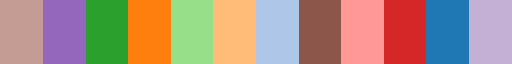

In [1377]:
# Seaborn colors
# try husl, hls, gnist_ncar
colors = sns.color_palette('tab20', len(to_plot_min)).as_hex()
random.seed(10); random.shuffle(colors)
criteria_map = {name: color for name, color in zip(to_plot_min, colors)}
cmap = ListedColormap(colors, name='Z'); cmap

In [1381]:
type(results_filter_min['webkb']['Performance Convergence']

list

## Metrics

In [1510]:
x_map = {results_plots[i][0].dataset_name: results_plots[i][1][0].x for i in range(len(results_plots))}
accuracy_map = {results_plots[i][0].dataset_name: np.mean([results_plots[i][1][j].accuracy_score for j in range(len(results_plots[i][1]))], axis=0) for i in range(len(results_plots))}
accuracy_upper_map = {results_plots[i][0].dataset_name: np.percentile([results_plots[i][1][j].accuracy_score for j in range(len(results_plots[i][1]))], 97.5, axis=0) for i in range(len(results_plots))}
accuracy_lower_map = {results_plots[i][0].dataset_name: np.percentile([results_plots[i][1][j].accuracy_score for j in range(len(results_plots[i][1]))], 2.5, axis=0) for i in range(len(results_plots))}
order = ['SSNCut', 'SC_entropy_mcs', 'SC_oracle_acc', 'Contradictory Information', 'Stabilizing Predictions', 'VM', 'EVM', 'Performance Convergence', 'Uncertainty Convergence', 'Max Confidence', 'Classification Change', 'Overall Uncertainty']
thresholds = {'SSNCut': None,
 'SC_entropy_mcs': 0.01,
 'SC_oracle_acc': 0.9,
 'SC_mes': 0.01,
 'Stabilizing Predictions': 0.99,
 'Performance Convergence': None,
 'Uncertainty Convergence': None,
 'Max Confidence': 0.001,
 'EVM': None,
 'VM': None,
 'Contradictory Information': None,
 'Overall Uncertainty': 0.01, 'Classification Change': None}
lims = {
    'SC_oracle_acc': (None, 1.),
    'SC_entropy_mcs': (0., None),
    'Contradictory Information': (0., None),
    'Stabilizing Predictions': (None, 1.),
    'Performance Convergence': (None, 1.),
    'Uncertainty Convergence': (0., None),
    'Max Confidence': (0., None),
    'Classification Change': (None, 1.),
    'Overall Uncertainty': (0, None),
    'VM': (0, None), 'EVM': (0, None),
}

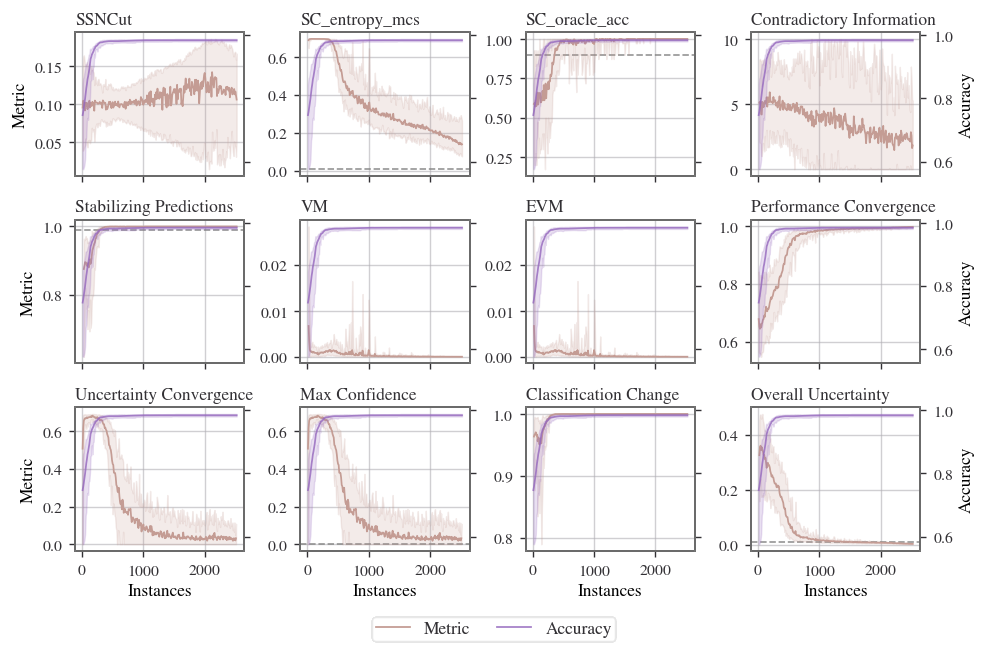

In [1557]:
def metrics_plot(results, dataset='spamassassin', figsize=(8.,5), dpi=125, cols=4, set_lims=True, plot_accuracy=True):
    conds = results[dataset]
    x = x_map[dataset]
    accuracy = accuracy_map[dataset]
    accuracy_upper = accuracy_upper_map[dataset]
    accuracy_lower = accuracy_lower_map[dataset]
    dataset = dataset.rstrip("-58509")
    
    fig, axes = plt.subplots(math.ceil(len(conds)/cols), cols, figsize=figsize, dpi=dpi)
    
    new = {}
    for name in order:
        new[name] = conds[name]
    conds = new
    
    for i, (ax, (cname, runs)) in enumerate(zip(axes.flatten(), conds.items())):
        ax.set_title(cname)
        ax.grid(alpha=0.6)
        
        mets = []
        for run in runs:
            if isinstance(run.metric, tuple):
                mets.append([*[np.nan]*(len(x)-len(run.metric[0])), *run.metric[0]])
            else:
                mets.append([*[np.nan]*(len(x)-len(run.metric)), *run.metric])
        mean = np.mean(mets, axis=0)
        upper = np.percentile(mets, 97.5, axis=0)
        lower = np.percentile(mets, 2.5, axis=0)
        
        # accuracy
        if plot_accuracy:
            ax2 = ax.twinx()
            l = ax2.plot(x, accuracy, lw=1., color=cmap(1), label="Accuracy" if i == 0 else None, alpha=0.8)
            ax2.fill_between(x, accuracy_lower, accuracy_upper, alpha=0.2, color=l[0].get_color())
                
        # Metric
        l = ax.plot(x, mean, lw=1., color=cmap(0), label="Metric" if i == 0 else None, zorder=5)
        ax.fill_between(x, lower, upper, alpha=0.2, color=l[0].get_color(), zorder=4)
        
        # Stop points
        
        # Thresholds
        if thresholds[cname] is not None:
            ax.axhline(thresholds[cname], color='grey', alpha=0.8, lw=1., ls='--')
        # Limits
        if cname in lims and set_lims:
            ax.set_ylim(lims[cname])
        
        if i % cols == 0:
            ax.set_ylabel("Metric")
        if i % cols == cols-1:
            ax2.set_ylabel("Accuracy")
        else:
            ax2.set_yticklabels(())
        if i > len(conds)-cols-1:
            ax.set_xlabel("Instances")
        else:
            ax.set_xticklabels(())
            
        for spine in ax2.spines.values():
            spine.set_edgecolor('#777')
            
        fig.legend(bbox_to_anchor=(0.5, -0.05), loc='lower center', ncol=2)
    
    fig.tight_layout(w_pad=0.5, h_pad=1.0)
    
with plt.style.context('plt_style.txt'):
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['axes.linewidth'] = 1
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True
    plt.rcParams['xtick.labelsize'] = 9
    plt.rcParams['ytick.labelsize'] = 9
    #plt.rcParams['lines.markeredgecolor']: black
    #plt.rcParams['patch.facecolor'] = 'bc80bd'
    #patch.force_edgecolor  : True
    #patch.linewidth: 0.8
    metrics_plot(results_filter_min, set_lims=False)

## Full Range Pareto Plots

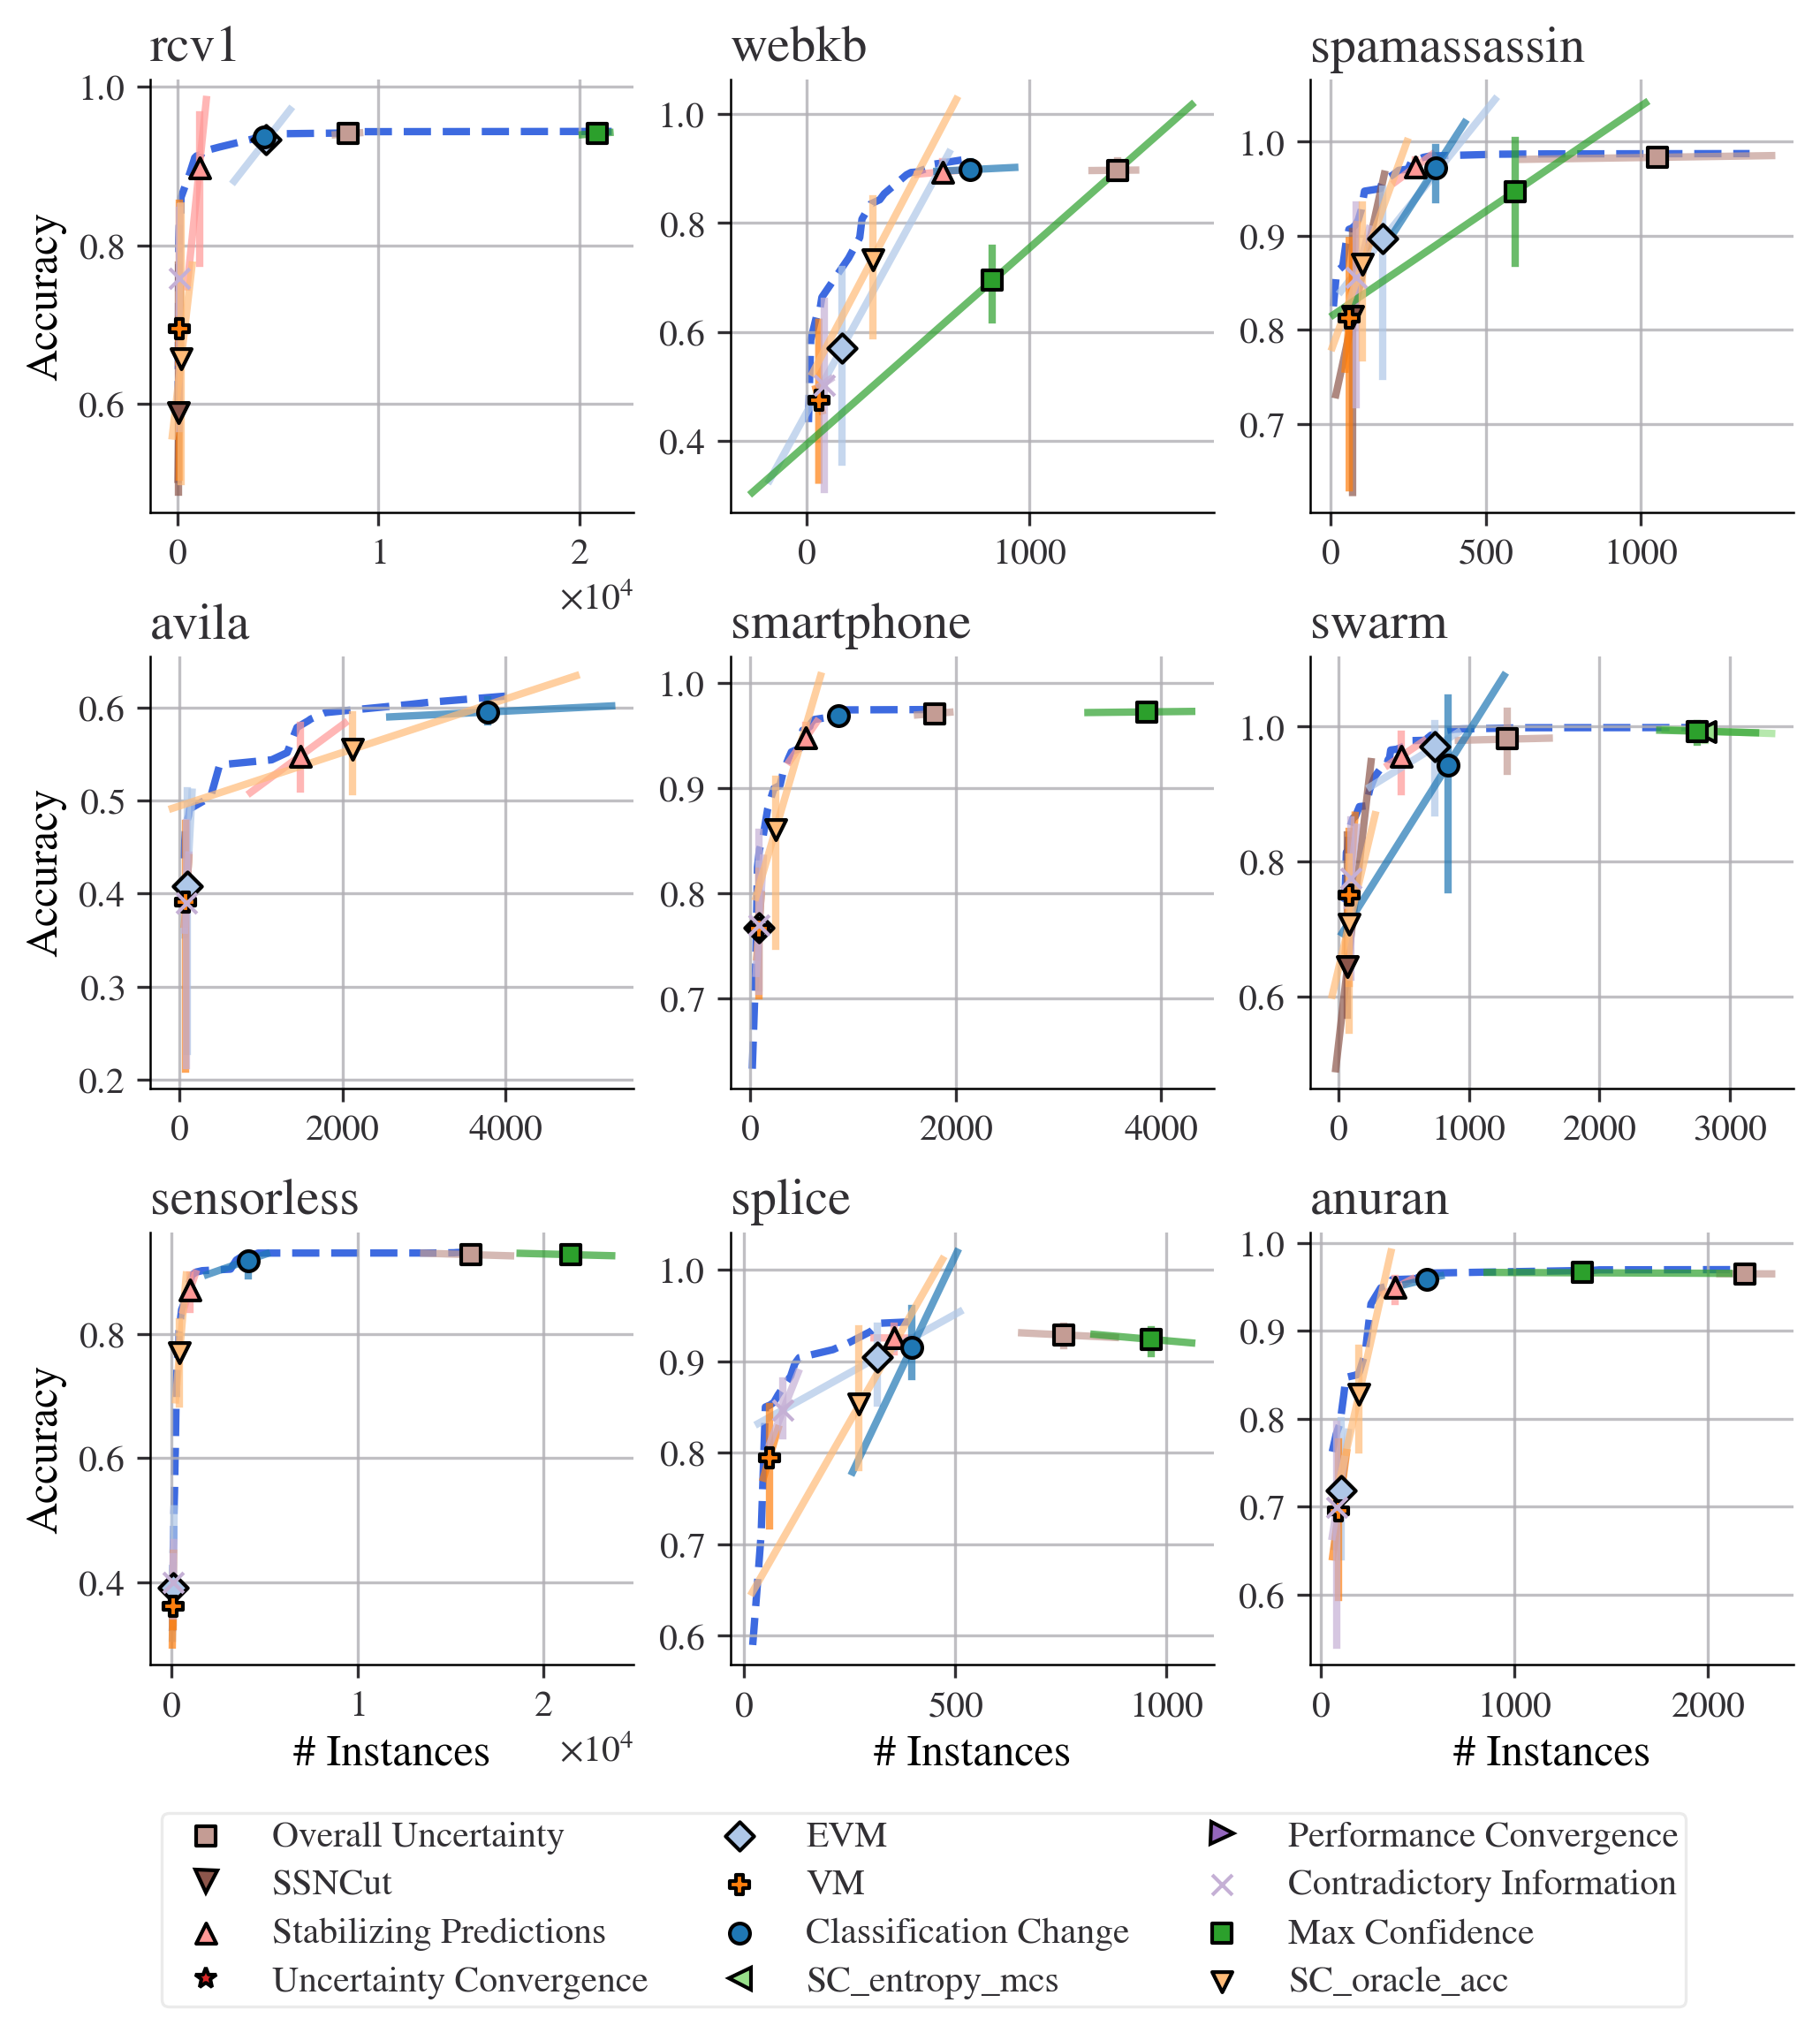

In [1379]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    plot_paraeto_hull(results_filter_min, rows=3, cols=3, figsize=(8,8), dpi=300, hull=False, error='pca', colors=criteria_map, legend_loc='upper center', legend_cols=3, legend_bbox=(-0.8, -0.3))

Errors drawn asymmetrically using 2.5% and 97.5% percentiles.

### Optimal Regions (Ranking Formula)

In [1000]:
reload(libregionplot); from libregionplot import regions, costs

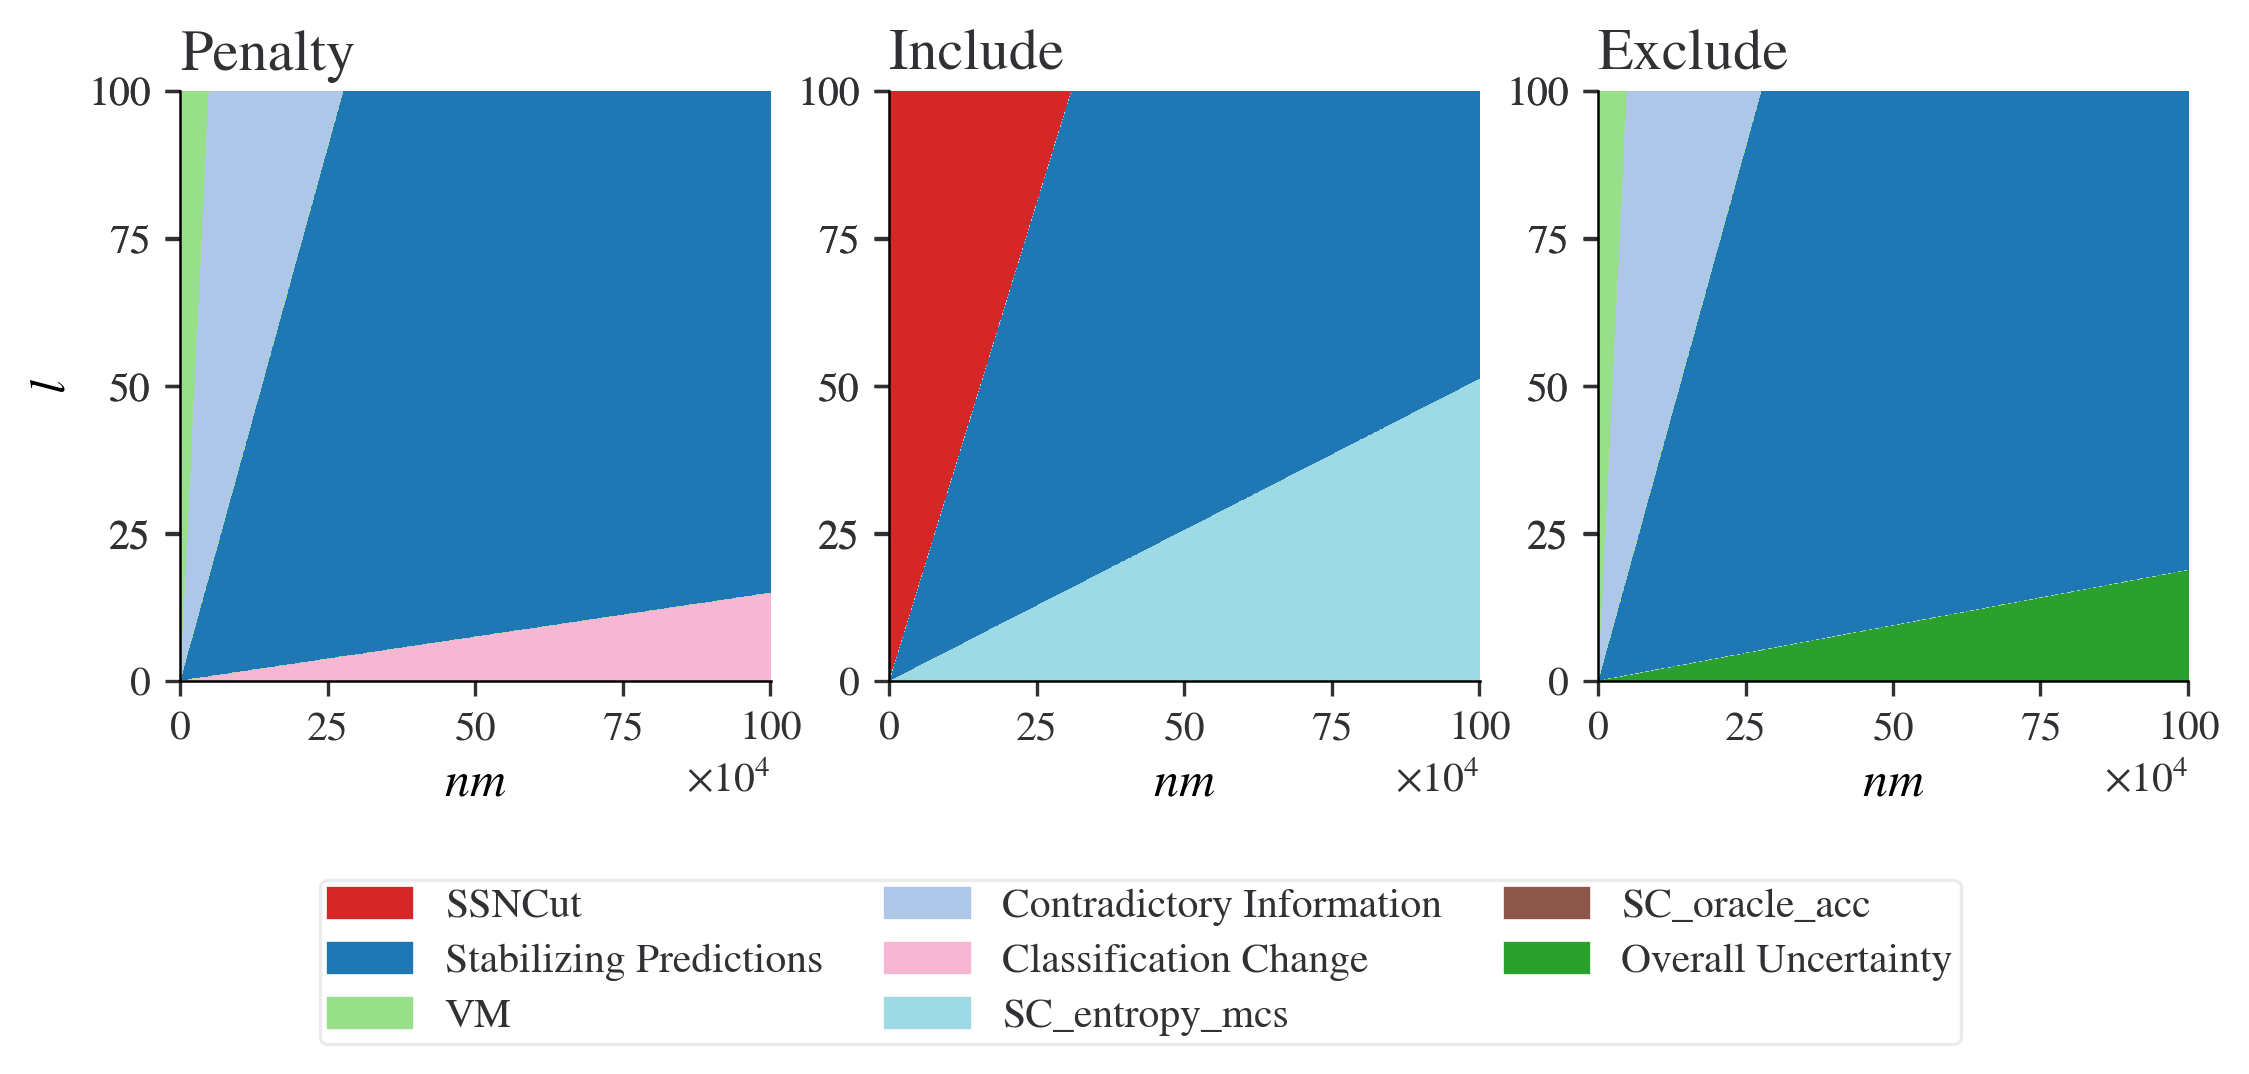

In [1348]:
reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1, 3, figsize=(7.2*1.2,4.45), dpi=300)
    patches = []
    for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
        regions(results_filter_min, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0)
    plt.legend(handles=patches, bbox_to_anchor=(0.65, -0.3), ncol=3)
#plt.tight_layout()

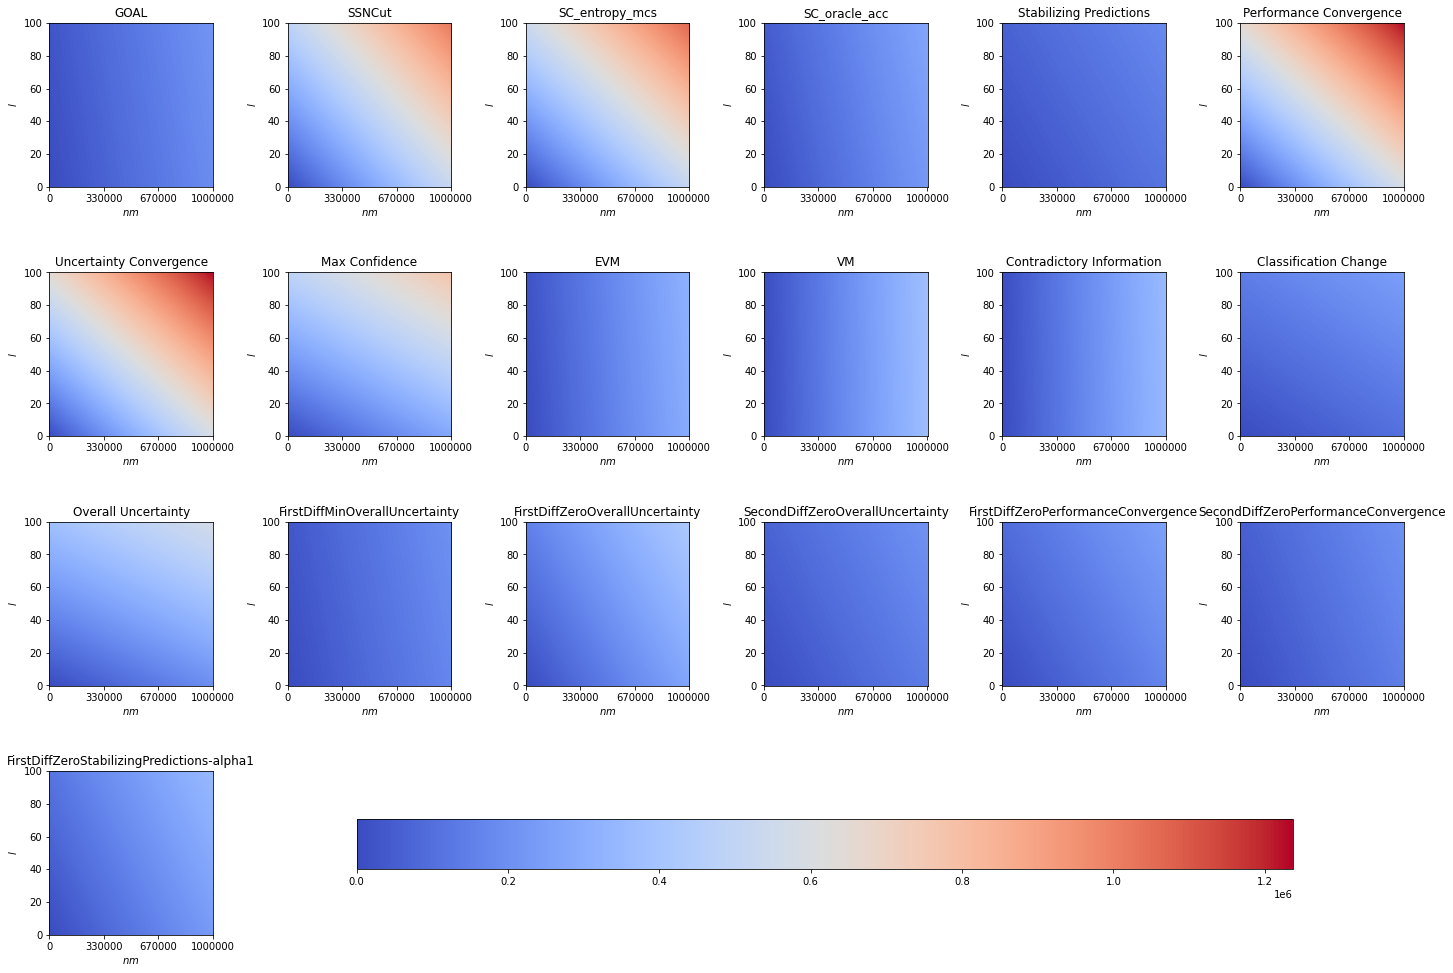

In [846]:
costs(results_filter)

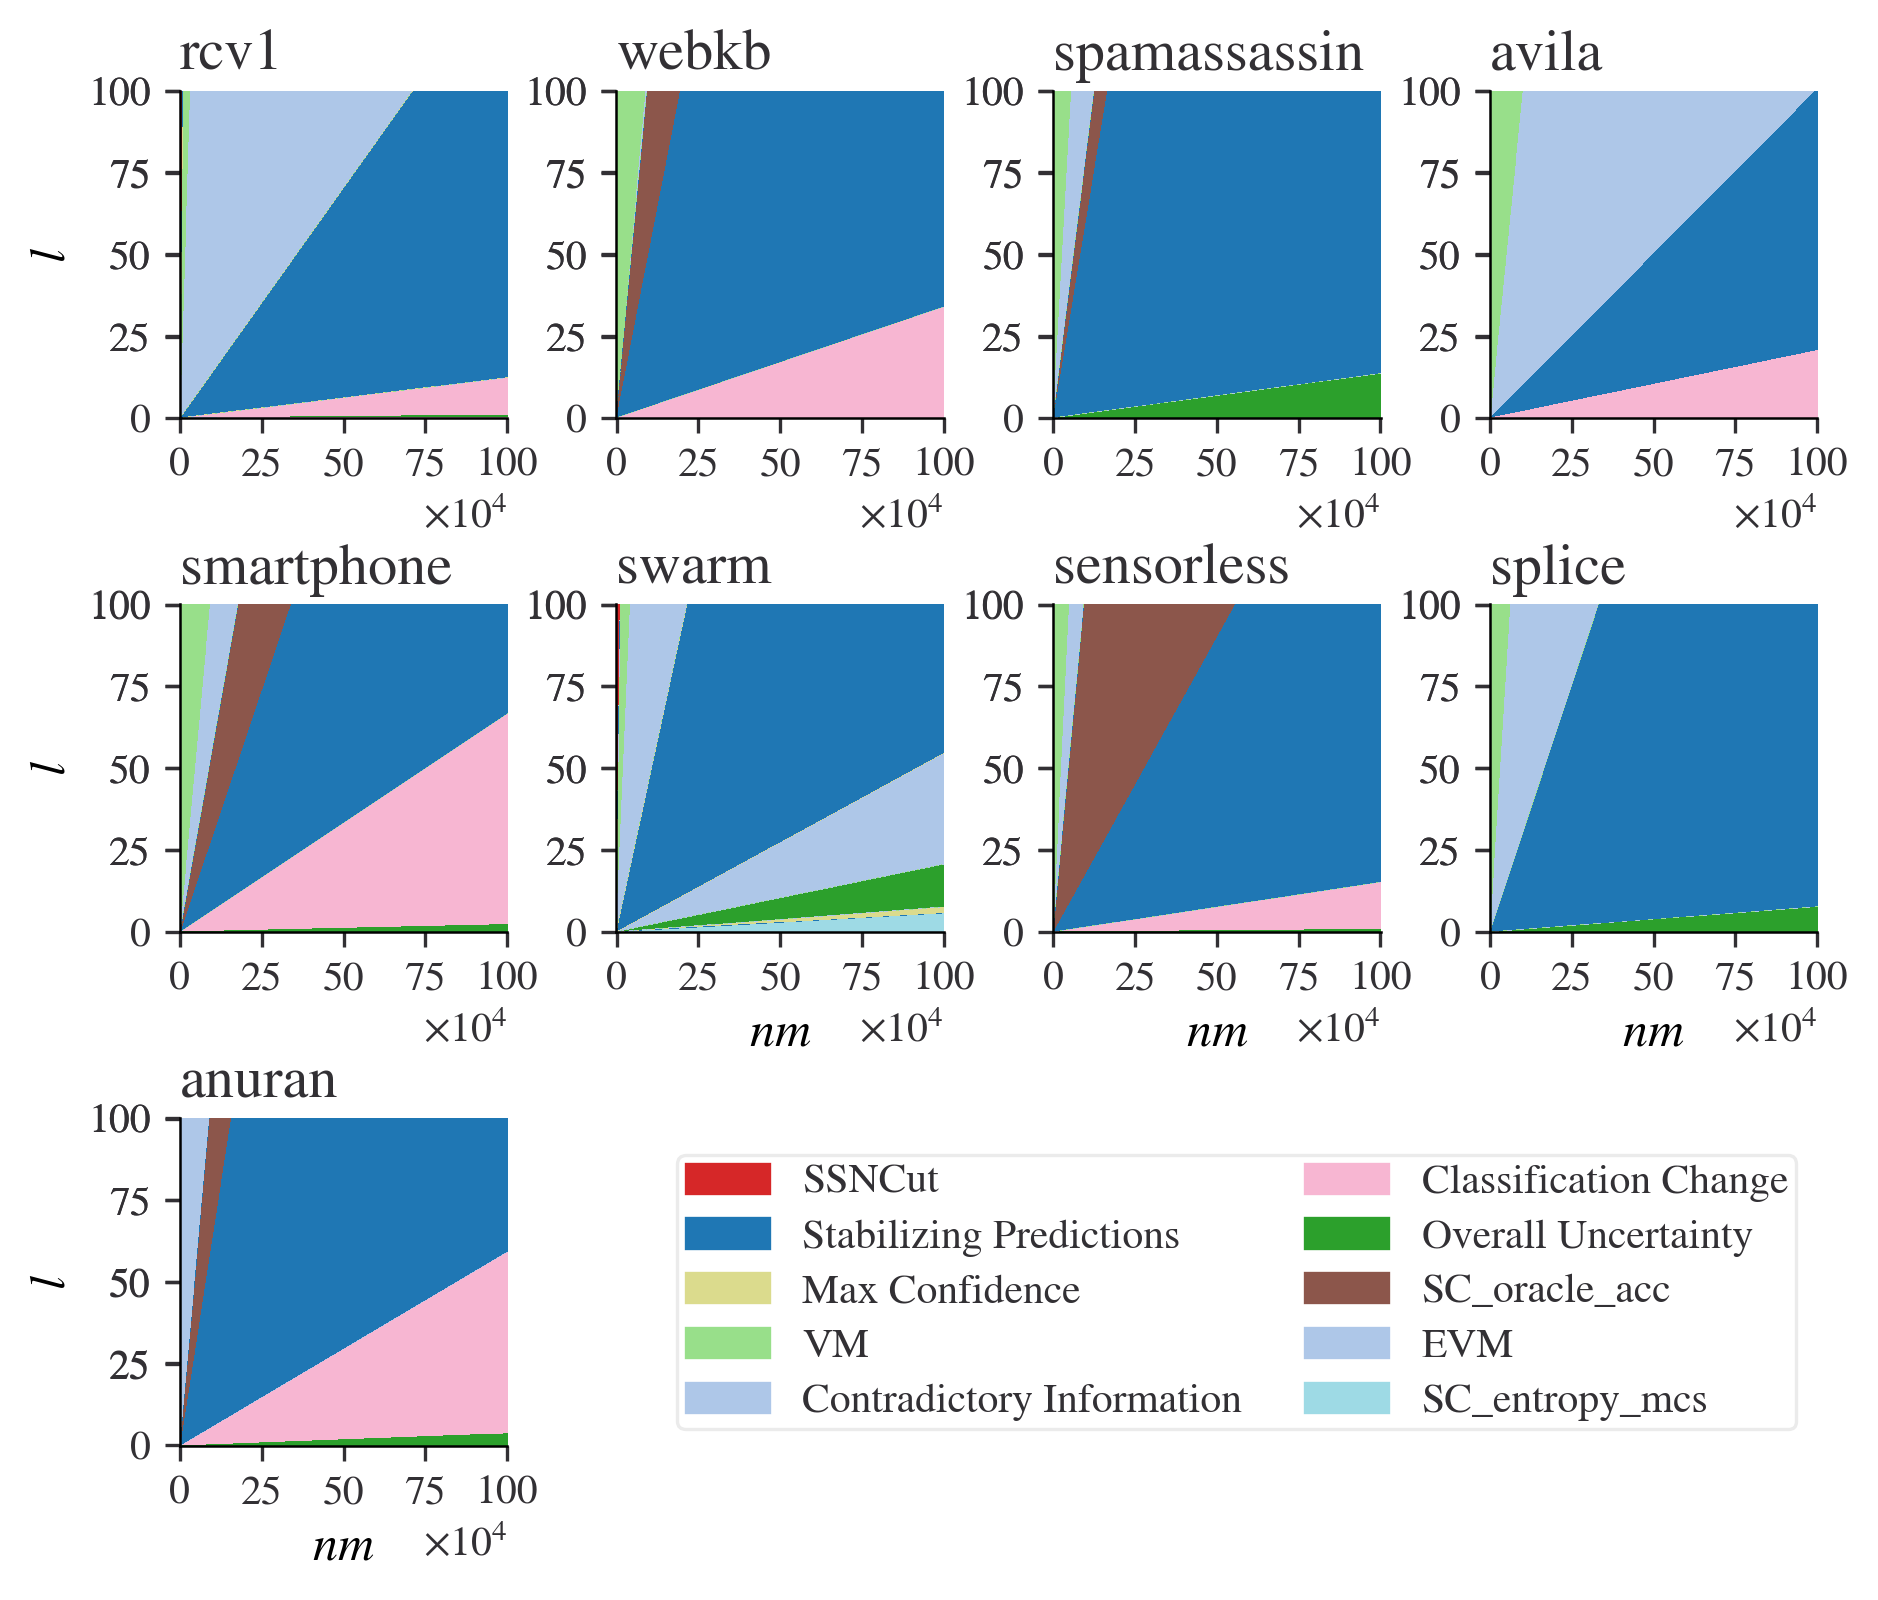

In [1349]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
import math
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(math.ceil(len(results_filter_min)/4), 4, figsize=(7.2,6.3), dpi=300)
    patches = []
    for i, ((dataset, r), ax) in enumerate(zip(results_filter_min.items(), axes.flatten())):
        regions(
            {dataset: r}, 
            colors=criteria_map, 
            failed_to_stop="penalty", 
            title=dataset.rstrip("-58509"), 
            ax=ax, 
            patches=patches, 
            left=i%4==0, 
            bottom=i>len(results_filter_min)-5)
    for ax in axes.flatten()[len(results_filter_min):]:
        fig.delaxes(ax)
    for ax in axes.flatten():
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
    plt.legend(handles=patches, bbox_to_anchor=(5., 0.95), ncol=2)
    #plt.suptitle("Linear SVM (Penalty)")

In [1350]:
reload(libstop)
import libregionplot; reload(libregionplot); from libregionplot import *
interactive_explore_cost(results_filter_min, title="Marketing Example")

interactive(children=(IntText(value=87600, description='Expected number of misclassifications n:'), FloatText(…

## Failed To Stop

In [1351]:
table = []
for dataset, methods in results_filter_min.items():
    table.append([])
    for method, results in methods.items():
        table[-1].append(f"{np.count_nonzero([result[0] for result in results])}/{len(results)}")

In [1353]:
tabulate(table, tablefmt='html', showindex=[s.rstrip("-58509") for s in results_filter_min.keys()], headers=results_filter_min['webkb'].keys())

,SSNCut,SC_entropy_mcs,SC_oracle_acc,Stabilizing Predictions,Performance Convergence,Uncertainty Convergence,Max Confidence,EVM,VM,Contradictory Information,Classification Change,Overall Uncertainty
rcv1,30/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
webkb,0/30,0/30,30/30,30/30,0/30,0/30,25/30,30/30,30/30,30/30,30/30,13/30
spamassassin,30/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
avila,30/30,0/30,0/30,30/30,30/30,0/30,0/30,0/30,30/30,30/30,30/30,0/30
smartphone,0/30,0/30,30/30,30/30,0/30,0/30,3/30,30/30,30/30,30/30,30/30,30/30
swarm,30/30,30/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
sensorless,0/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
splice,0/30,0/30,30/30,30/30,0/30,0/30,26/30,30/30,30/30,30/30,30/30,30/30
anuran,0/30,0/30,30/30,30/30,0/30,0/30,5/30,30/30,30/30,30/30,30/30,30/30


In [1337]:
import pandas as pd

In [1354]:
pd.DataFrame(table, [s.rstrip("-58509") for s in results_filter_min.keys()], list(results_filter_min['webkb'].keys())).to_csv('failed_to_stop.csv')

## Raw Results

In [93]:
table = []
for dataset, methods in results_filter.items():
    for method, results in methods.items():
        r = np.array(results)
        r = r[r[:,0]!=None]
        if len(r) == 0:
            table.append([dataset, method, *[None]*3])
            continue
        
        mean = np.mean(r, axis=0)
        # 2.5% percentile to 97.5%
        lower = np.percentile(r, 2.5, axis=0)
        upper = np.percentile(r, 97.5, axis=0)
        
        data = []
        for i in range(4):
            #data.append(f"{upper[i]:.2f}|{mean[i]:.2f}|{lower[i]:.2f}")
            data.append(upper[i])
            data.append(mean[i])
            data.append(lower[i])
    
        table.append(
            [dataset, method, *data]
        )

In [94]:
tabulate(
    table,
    tablefmt='html',
    headers=['Dataset', 'Method', 'Instances (Upper)', "Instances (Mean)", 'Instances (Lower)', 'Accuracy (Upper)', 'Accuracy (Mean)', 'Accuracy (Lower)', 'F1 (Upper)', 'F1 (Mean)', 'F1 (Lower)', 'ROC (Upper)', 'ROC (Mean)', 'ROC (Lower)'],
    floatfmt=('', '', *['g']*3, *['.2%']*6)
)

Dataset,Method,Instances (Upper),Instances (Mean),Instances (Lower),Accuracy (Upper),Accuracy (Mean),Accuracy (Lower),F1 (Upper),F1 (Mean),F1 (Lower),ROC (Upper),ROC (Mean),ROC (Lower)
webkb,GOAL,434.25,278,131.25,87.83%,74.46%,57.02%,87.83%,74.46%,57.02%,0.965526,0.913381,0.828042
webkb,SSNCut,,,,,,,,,,,,
webkb,SC_entropy_mcs,,,,,,,,,,,,
webkb,SC_oracle_acc,646,296,44.5,89.11%,71.23%,36.26%,89.11%,71.23%,36.26%,0.97251,0.886621,0.736938
webkb,Stabilizing Predictions,745.25,615,544.5,90.87%,89.00%,87.48%,90.87%,89.00%,87.48%,0.973699,0.965195,0.941108
webkb,Performance Convergence,,,,,,,,,,,,
webkb,Uncertainty Convergence,,,,,,,,,,,,
webkb,Max Confidence,1540,750,10,89.70%,66.25%,30.05%,89.70%,66.25%,30.05%,0.977654,0.717228,0.28901
webkb,EVM,616.5,200,50,88.78%,58.46%,34.19%,88.78%,58.46%,34.19%,0.956576,0.841857,0.750883
webkb,VM,70,56,50,58.47%,44.35%,32.46%,58.47%,44.35%,32.46%,0.844025,0.778234,0.71372
